In [1]:
!pip uninstall -y numpy pandas
!pip install pandas==2.2.2 numpy==1.26.4 alpaca-py ta xgboost matplotlib tqdm python-dotenv yfinance scikit-learn joblib --quiet --disable-pip-version-check --no-deps


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2


In [2]:
import os
from datetime import datetime, timedelta, timezone

import numpy as np
import pandas as pd
from tqdm import tqdm

# Yahoo Finance data
import yfinance as yf

# Technical indicators
import ta

# Model
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib

# Visualization
import matplotlib.pyplot as plt

# For environment variables (optional if storing ticker or API keys)
from dotenv import load_dotenv
load_dotenv()


False

In [28]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)  # suppress FutureWarnings

symbol = "AAPL"

def fetch_data(symbol, interval, days_back):
    """
    Fetch historical stock data from Yahoo Finance in chunks to avoid limitations.
    """
    end_date = datetime.utcnow()
    start_date = end_date - timedelta(days=days_back)
    data_all = []

    # yahoo limits for 1m data (~7 days)
    chunk_days = 6 if interval == "1m" else days_back

    current_start = start_date
    while current_start < end_date:
        current_end = min(current_start + timedelta(days=chunk_days), end_date)
        try:
            df_chunk = yf.download(
                symbol,
                interval=interval,
                start=current_start.strftime("%Y-%m-%d"),
                end=current_end.strftime("%Y-%m-%d"),
                progress=False,
                auto_adjust=False  # explicitly set to remove FutureWarning
            )
            if not df_chunk.empty:
                data_all.append(df_chunk)
        except Exception as e:
            print(f"Error fetching {interval} data: {e}")
        current_start = current_end

    if data_all:
        df = pd.concat(data_all)
        df = df[~df.index.duplicated(keep="first")]
        df.sort_index(inplace=True)
        return df
    else:
        return pd.DataFrame()

def sanitize_dataframe(df):
    if df.empty:
        return df
    df = df.copy()
    # flatten MultiIndex columns if needed
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] for col in df.columns]

    for col in ["Open", "High", "Low", "Close", "Volume"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").astype(float)
    return df

# -------- fetch both --------
df_1min = fetch_data(symbol, "1m", days_back=29)   # ✅ max ~7 days per chunk
df_1h   = fetch_data(symbol, "1h", days_back=729) # ✅ 2 years of data

df_1min = sanitize_dataframe(df_1min)
df_1h   = sanitize_dataframe(df_1h)

print("1m shape:", df_1min.shape)
print("1h shape:", df_1h.shape)


1m shape: (7774, 6)
1h shape: (3473, 6)


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import ta
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler

# ======================================================
# 1. CLEAN + FEATURES
# ======================================================
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [c[0] for c in df.columns]
    needed = ["Open","High","Low","Close","Volume"]
    for c in needed:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna().sort_index()
    if df.index.tz is None:
        df.index = df.index.tz_localize("UTC")
    return df

def _flat(df, series):
    return pd.Series(np.asarray(series, dtype=float).ravel(), index=df.index)

def add_indicators(df: pd.DataFrame, mode="1m"):
    df = df.copy()
    # Returns & vol
    df["ret_1"] = df["Close"].pct_change()
    for k in [2,3,5]:
        df[f"ret_{k}"] = df["Close"].pct_change(k)
    df["vol_20"] = df["Close"].pct_change().rolling(20).std()
    df["z_close_20"] = (df["Close"]-df["Close"].rolling(20).mean())/(df["Close"].rolling(20).std()+1e-12)

    # VWAP
    pv = (df["Close"]*df["Volume"]).cumsum()
    vv = df["Volume"].replace(0,np.nan).cumsum()
    df["vwap_cum"] = pv/vv

    if mode=="1m":
        df["rsi_2"] = _flat(df, ta.momentum.RSIIndicator(df["Close"],2).rsi())
        df["rsi_7"] = _flat(df, ta.momentum.RSIIndicator(df["Close"],7).rsi())
        for w in [5,10,20]:
            df[f"ema_{w}"] = _flat(df, ta.trend.EMAIndicator(df["Close"],w).ema_indicator())
        bb = ta.volatility.BollingerBands(df["Close"],20,2)
        df["bb_perc"] = _flat(df, bb.bollinger_pband())
        df["vol_spike"] = df["Volume"]/ (df["Volume"].rolling(20).mean()+1e-12)
        for w in [5,10,20]:
            df[f"dist_ema_{w}"] = df["Close"]/df[f"ema_{w}"] - 1.0
        df["dist_vwap"] = df["Close"]/df["vwap_cum"] - 1.0

    elif mode=="1h":
        df["rsi_14"] = _flat(df, ta.momentum.RSIIndicator(df["Close"],14).rsi())
        df["rsi_28"] = _flat(df, ta.momentum.RSIIndicator(df["Close"],28).rsi())
        macd = ta.trend.MACD(df["Close"])
        df["macd"], df["macd_sig"] = _flat(df,macd.macd()), _flat(df,macd.macd_signal())
        for w in [20,50,100]:
            df[f"ema_{w}"] = _flat(df, ta.trend.EMAIndicator(df["Close"],w).ema_indicator())
        atr = ta.volatility.AverageTrueRange(df["High"],df["Low"],df["Close"],14)
        df["atrp_14"] = _flat(df, atr.average_true_range())/(df["Close"]+1e-12)
        for w in [20,50,100]:
            df[f"dist_ema_{w}"] = df["Close"]/df[f"ema_{w}"] - 1.0
        df["dist_vwap"] = df["Close"]/df["vwap_cum"] - 1.0

    return df.replace([np.inf,-np.inf],np.nan).dropna()

def make_labels(df,horizon=5,thr_bps=6):
    df=df.copy()
    fwd=df["Close"].shift(-horizon)/df["Close"] - 1
    thr=thr_bps/10000
    df["target"]=np.where(fwd>thr,1,np.where(fwd<-thr,-1,0))
    df["fwd_ret_h"]=fwd
    return df.dropna()

# ======================================================
# 2. LABEL MAPPING
# ======================================================
def remap_labels(y):
    """Convert {-1,0,1} -> {0,1,2}"""
    y = np.array(y)
    return np.where(y==-1,0,np.where(y==0,1,2))

def inverse_remap(y):
    """Convert {0,1,2} -> {-1,0,1}"""
    y = np.array(y)
    return np.where(y==0,-1,np.where(y==1,0,1))

# ======================================================
# 3. MODEL + CV
# ======================================================
def time_series_folds(n_samples,n_folds=5,min_train_frac=0.6):
    start=int(n_samples*min_train_frac)
    fold=(n_samples-start)//n_folds
    for i in range(n_folds):
        te0=start+i*fold
        te1=start+(i+1)*fold if i<n_folds-1 else n_samples
        yield slice(0,te0), slice(te0,te1)

def train_xgb(X_tr, y_tr, X_val, y_val, sample_weight=None):
    model = XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
        random_state=42,
    )
    model.fit(
        X_tr, y_tr,
        sample_weight=sample_weight,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    return model

def walk_forward_cv(df, mode="1m", n_folds=5, tx_cost_bps=1.0, scaler=None):
    drop_cols=["Open","High","Low","Close","Volume","fwd_ret_h","target"]
    feats=[c for c in df.columns if c not in drop_cols]
    X,y=df[feats].values,df["target"].values

    if scaler:
        X=scaler.fit_transform(X)

    # class weights
    vals,cts=np.unique(y,return_counts=True)
    weights={v:1.0/c for v,c in zip(vals,cts)}
    sample_w=np.vectorize(lambda z:weights[z])(y)

    eq_curves=[]; reports=[]
    for tr,te in time_series_folds(len(X),n_folds):
        Xtr,ytr,Xte,yte = X[tr], y[tr], X[te], y[te]
        sw_tr = sample_w[tr]

        cut=int(len(Xtr)*0.9)
        X_tr_sub, y_tr_sub = Xtr[:cut], remap_labels(ytr[:cut])
        X_val_sub, y_val_sub = Xtr[cut:], remap_labels(ytr[cut:])
        yte_mapped = remap_labels(yte)

        model = train_xgb(X_tr_sub, y_tr_sub, X_val_sub, y_val_sub, sample_weight=sw_tr[:cut])

        pred = model.predict(Xte)
        reports.append(classification_report(yte_mapped, pred, labels=[0,1,2],
                                             target_names=["short","hold","long"],
                                             output_dict=True, zero_division=0))

        # back to {-1,0,1} for trading
        pred_trading = inverse_remap(pred)
        df_slice = df.iloc[te].copy()
        df_slice["pos"] = pd.Series(pred_trading,index=df_slice.index).shift().fillna(0)
        pnl = df_slice["pos"]*df_slice["fwd_ret_h"]
        cost = (df_slice["pos"]!=df_slice["pos"].shift()).astype(int)*(tx_cost_bps/10000)
        pnl_net = pnl - cost
        eq_curves.append((1+pnl_net).cumprod())

    eq = pd.concat(eq_curves,axis=1).fillna(method="ffill").fillna(1.0)
    eq_mean = eq.mean(axis=1)
    print(f"{mode} Final Equity {eq_mean.iloc[-1]:.2f}x")
    return eq_mean, reports, feats

# ======================================================
# 4. PIPELINE
# ======================a================================
def run_pipeline(df, mode, horizon, thr_bps, scaler=None, save_path=None):
    df = clean_dataframe(df)
    df = add_indicators(df, mode=mode)
    df = make_labels(df, horizon=horizon, thr_bps=thr_bps)
    eq, reports, feats = walk_forward_cv(df, mode=mode, scaler=scaler)
    if save_path:
        X,y = df[feats].values, remap_labels(df["target"].values)
        cut=int(len(X)*0.9)
        model = train_xgb(X[:cut], y[:cut], X[cut:], y[cut:])
        joblib.dump({"model":model, "features":feats, "mode":mode}, save_path)
        print(f"Saved {mode} model to {save_path}")
    return eq, reports


In [33]:
eq1m, rep1m = run_pipeline(df_1min, "1m", horizon=5, thr_bps=6, scaler=RobustScaler(), save_path="xgb_1m.pkl")
eq1h, rep1h = run_pipeline(df_1h, "1h", horizon=3, thr_bps=10, scaler=RobustScaler(), save_path="xgb_1h.pkl")


1m Final Equity 0.91x
Saved 1m model to xgb_1m.pkl
1h Final Equity 0.97x
Saved 1h model to xgb_1h.pkl


In [34]:
# ===============================
# TRAIN-TEST + METRICS EVALUATION
# ===============================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(df, mode="1m", horizon=5, thr_bps=6):
    # Train-test pipeline
    model, feats, scaler = train_test_pipeline(df, mode=mode, horizon=horizon, thr_bps=thr_bps)

    # Prepare test set for metrics
    df_clean = clean_dataframe(df)
    df_feat = add_indicators(df_clean, mode=mode)
    df_label = make_labels(df_feat, horizon=horizon, thr_bps=thr_bps)

    drop_cols = ["Open","High","Low","Close","Volume","fwd_ret_h","target"]
    X = df_label[feats].values
    y = remap_labels(df_label["target"].values)

    # Train-test split
    split_idx = int(len(X)*0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Scale test
    X_test_scaled = scaler.transform(X_test)

    # Predict
    y_pred = model.predict(X_test_scaled)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec_macro = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec_macro  = recall_score(y_test, y_pred, average="macro", zero_division=0)
    f1_macro   = f1_score(y_test, y_pred, average="macro", zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    print(f"=== {mode} Test Set Metrics ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec_macro:.4f}")
    print(f"Recall   : {rec_macro:.4f}")
    print(f"F1-score : {f1_macro:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, labels=[0,1,2],
                                target_names=["short","hold","long"], zero_division=0))
    return model, feats, scaler

# ===============================
# RUN ON 1m AND 1h DATA
# ===============================
model_1m, feats_1m, scaler_1m = evaluate_model(df_1min, mode="1m", horizon=5, thr_bps=6)
model_1h, feats_1h, scaler_1h = evaluate_model(df_1h, mode="1h", horizon=3, thr_bps=10)

# Save models
joblib.dump({"model":model_1m, "features":feats_1m, "mode":"1m"}, "xgb_1m.pkl")
joblib.dump({"model":model_1h, "features":feats_1h, "mode":"1h"}, "xgb_1h.pkl")
print("Models saved successfully.")


=== Test Set Classification Report ===
              precision    recall  f1-score   support

       short       0.31      0.91      0.46       457
        hold       0.46      0.14      0.22       617
        long       0.00      0.00      0.00       476

    accuracy                           0.33      1550
   macro avg       0.26      0.35      0.23      1550
weighted avg       0.27      0.33      0.22      1550

=== 1m Test Set Metrics ===
Accuracy : 0.3258
Precision: 0.2560
Recall   : 0.3519
F1-score : 0.2254
Confusion Matrix:
[[418  39   0]
 [528  87   2]
 [413  63   0]]

Classification Report:
              precision    recall  f1-score   support

       short       0.31      0.91      0.46       457
        hold       0.46      0.14      0.22       617
        long       0.00      0.00      0.00       476

    accuracy                           0.33      1550
   macro avg       0.26      0.35      0.23      1550
weighted avg       0.27      0.33      0.22      1550

=== Test Se

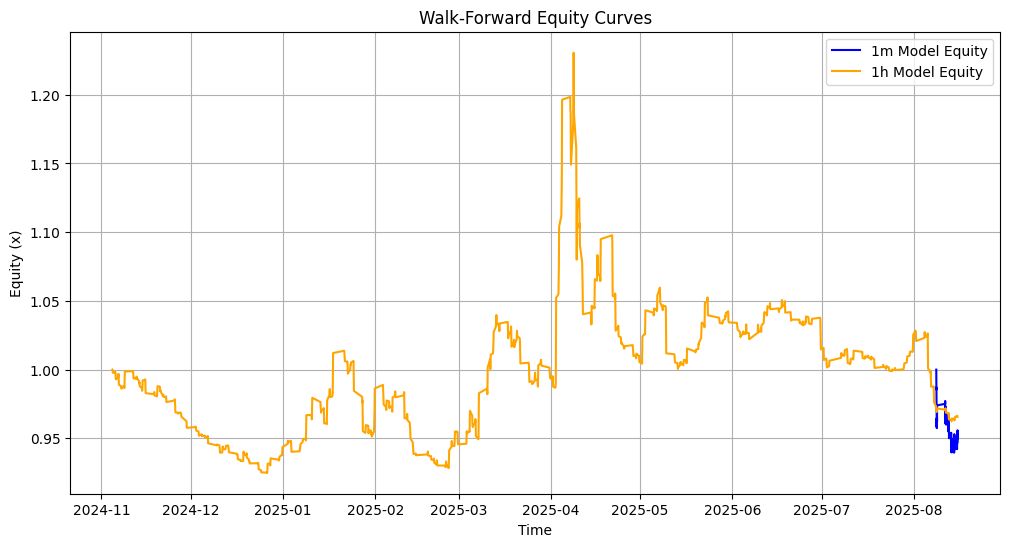

In [22]:
import matplotlib.pyplot as plt
import joblib

# Assuming eq1m and eq1h are already in memory from run_pipeline
plt.figure(figsize=(12,6))

plt.plot(eq1m.index, eq1m.values, label="1m Model Equity", color="blue")
plt.plot(eq1h.index, eq1h.values, label="1h Model Equity", color="orange")

plt.title("Walk-Forward Equity Curves")
plt.xlabel("Time")
plt.ylabel("Equity (x)")
plt.legend()
plt.grid(True)
plt.show()


In [32]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import joblib
import numpy as np
import pandas as pd
from datetime import datetime

# Load trained models and features
model_1m_data = joblib.load("xgb_1m.pkl")
model_1h_data = joblib.load("xgb_1h.pkl")

model_1m = model_1m_data["model"]
features_1m = model_1m_data["features"]
model_1h = model_1h_data["model"]
features_1h = model_1h_data["features"]

# Store live predictions
live_predictions = []

# Equity tracking
equity = 1.0
equity_curve = []

# Number of iterations for testing
iterations = 10
symbol = "AAPL"

for i in range(iterations):
    # ---------------------------
    # Fetch latest 1-minute data
    # ---------------------------
    df_1m_live = fetch_data(symbol, "1m", days_back=1)
    df_1m_live = sanitize_dataframe(df_1m_live)

    if df_1m_live.empty:
        print(f"No 1-minute data available for {symbol} at {datetime.utcnow()}")
        time.sleep(60)
        continue

    df_1m_live = add_indicators(df_1m_live, mode="1m")

    # ---------------------------
    # Fetch latest 1-hour data
    # ---------------------------
    df_1h_live = fetch_data(symbol, "1h", days_back=30)
    df_1h_live = sanitize_dataframe(df_1h_live)

    if df_1h_live.empty:
        print(f"No 1-hour data available for {symbol} at {datetime.utcnow()}")
        time.sleep(60)
        continue

    df_1h_live = add_indicators(df_1h_live, mode="1h")

    # ---------------------------
    # Prepare features and predict
    # ---------------------------
    X_1m = df_1m_live[features_1m].values[-1].reshape(1, -1)
    X_1h = df_1h_live[features_1h].values[-1].reshape(1, -1)

    pos_1m = inverse_remap(model_1m.predict(X_1m))[0]
    pos_1h = inverse_remap(model_1h.predict(X_1h))[0]

    # Combine signals (confirmation)
    final_signal = pos_1m if pos_1m == pos_1h else 0

    # Save prediction
    live_predictions.append({
        "datetime": datetime.utcnow(),
        "signal": final_signal,
        "pos_1m": pos_1m,
        "pos_1h": pos_1h
    })

    # ---------------------------
    # Update equity curve (simulate 1-min return)
    # ---------------------------
    if len(df_1m_live) > 1:
        fwd_ret = df_1m_live["Close"].pct_change().iloc[-1]
        equity *= (1 + final_signal * fwd_ret)
        equity_curve.append(equity)

    # ---------------------------
    # Real-time plot
    # ---------------------------
    clear_output(wait=True)
    plt.figure(figsize=(12,6))
    plt.plot(equity_curve, label="Live 1m Equity", color="blue")
    plt.title("Live 1-Minute Model Equity Curve")
    plt.xlabel("Iteration")
    plt.ylabel("Equity (x)")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"{datetime.utcnow()} | 1m: {pos_1m}, 1h: {pos_1h}, final: {final_signal}, equity: {equity:.4f}")

    # Wait until next 1-minute candle
    time.sleep(60)


/tmp/ipython-input-1581888188.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_chunk = yf.download(
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-08-16 -> 2025-08-17)')


No 1-minute data available for AAPL at 2025-08-17 14:16:37.372184


/tmp/ipython-input-1581888188.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_chunk = yf.download(
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-08-16 -> 2025-08-17)')


No 1-minute data available for AAPL at 2025-08-17 14:17:37.389802


/tmp/ipython-input-1581888188.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_chunk = yf.download(
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-08-16 -> 2025-08-17)')


No 1-minute data available for AAPL at 2025-08-17 14:18:37.407251


/tmp/ipython-input-1581888188.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_chunk = yf.download(
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-08-16 -> 2025-08-17)')


No 1-minute data available for AAPL at 2025-08-17 14:19:37.424077


/tmp/ipython-input-1581888188.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_chunk = yf.download(
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-08-16 -> 2025-08-17)')


No 1-minute data available for AAPL at 2025-08-17 14:20:37.441442


/tmp/ipython-input-1581888188.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_chunk = yf.download(
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-08-16 -> 2025-08-17)')


No 1-minute data available for AAPL at 2025-08-17 14:21:37.458855


/tmp/ipython-input-1581888188.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_chunk = yf.download(
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-08-16 -> 2025-08-17)')


No 1-minute data available for AAPL at 2025-08-17 14:22:37.476295


/tmp/ipython-input-1581888188.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_chunk = yf.download(
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-08-16 -> 2025-08-17)')


No 1-minute data available for AAPL at 2025-08-17 14:23:37.493066


/tmp/ipython-input-1581888188.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_chunk = yf.download(
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-08-16 -> 2025-08-17)')


No 1-minute data available for AAPL at 2025-08-17 14:24:37.510401


/tmp/ipython-input-1581888188.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_chunk = yf.download(
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-08-16 -> 2025-08-17)')


No 1-minute data available for AAPL at 2025-08-17 14:25:37.528881


In [24]:
# -----------------------------
# Fetch 29 days of 1-minute data
# -----------------------------
df_1min = fetch_data(symbol, "1m", days_back=29)
df_1min = sanitize_dataframe(df_1min)
df_1min = add_indicators(df_1min, mode="1m")
df_1min = make_labels(df_1min, horizon=5, thr_bps=6)

# -----------------------------
# Slice test data: days 16 to 29
# -----------------------------
minutes_per_day = 390  # approx. market minutes per day
start_minute = 29*minutes_per_day - (29-16)*minutes_per_day  # starting index for day 16
end_minute = 29*minutes_per_day - 1  # last minute of day 29

if len(df_1min) < end_minute:
    end_minute = len(df_1min) - 1
if len(df_1min) < start_minute:
    start_minute = 0

df_test = df_1min.iloc[start_minute:end_minute+1]

# -----------------------------
# Prepare test data
# -----------------------------
features_1m = [f for f in features_1m if f in df_test.columns]
X_test = df_test[features_1m].values
y_test = remap_labels(df_test["target"].values)

# -----------------------------
# Predict and evaluate
# -----------------------------
if len(X_test) == 0:
    print("No test data available. Check how many minutes you fetched.")
else:
    y_pred = model_1m.predict(X_test)
    report = classification_report(
        y_test, y_pred,
        labels=[0, 1, 2],
        target_names=["short", "hold", "long"],
        zero_division=0
    )
    print("=== Accuracy Report on Test Set (Days 16-29) ===")
    print(report)


ValueError: Feature shape mismatch, expected: 19, got 1